In [35]:
from google.colab import drive
drive.mount('/content/drive')


import string
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
# Loading the dataset from drive
data = pd.read_csv('24_train_1.csv') #Loading Raw Train Data
test = pd.read_csv('news-test.csv') #Loading Raw Test Data

In [38]:
#1 PRE-PROCESSING RAW TRAINING DATA
# Using Preprocessing functions from HW 0
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

processed_docs = [get_tokens(articles) for articles in data['Text']]
processed_docs_str = [' '.join(doc) for doc in processed_docs]

In [39]:
# Vectorizing the processed text
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # Including unigrams and bigrams
X = tfidf_vectorizer.fit_transform(processed_docs_str)
y = data['Category']

In [40]:
# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
#2.1 DECISION TREE - SPLITTING THE DATA, SETTING CRITERIA AND BAR CHART
# Train and evaluate the decision tree models
criteria = ['gini', 'entropy']
accuracies = {}

In [42]:
for criterion in criteria:
    dt = DecisionTreeClassifier(criterion=criterion, random_state=42)
    dt.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, dt.predict(X_train))
    val_acc = accuracy_score(y_val, dt.predict(X_val))
    accuracies[criterion] = {'Training': train_acc, 'Validation': val_acc}
print(accuracies)

#Printing the Trraining and Validation accuracies for Gini and Entropy
training_accuracy = [accuracies['gini']['Training'], accuracies['entropy']['Training']]
validation_accuracy = [accuracies['gini']['Validation'], accuracies['entropy']['Validation']]

print(training_accuracy)
print(validation_accuracy)

{'gini': {'Training': 1.0, 'Validation': 0.81}, 'entropy': {'Training': 1.0, 'Validation': 0.73}}
[1.0, 1.0]
[0.81, 0.73]


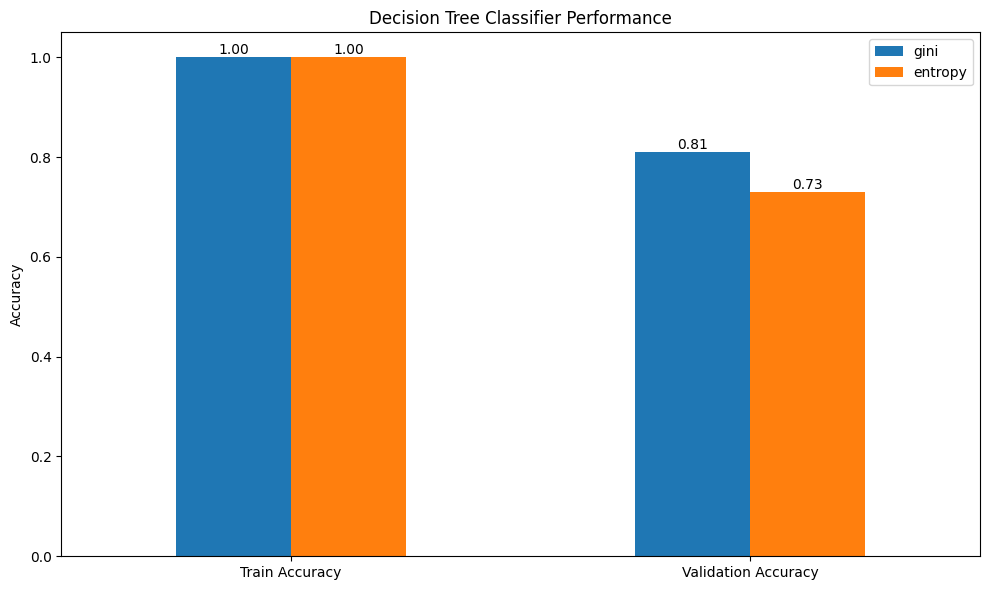

In [43]:
res = {'gini':[], 'entropy': []}
res['gini'].append(accuracies['gini']['Training'])
res['gini'].append(accuracies['gini']['Validation'])

res['entropy'].append(accuracies['entropy']['Training'])
res['entropy'].append(accuracies['entropy']['Validation'])

# Plotting the accuracies
ax = pd.DataFrame(res, index=["Train Accuracy", "Validation Accuracy"]).plot.bar(rot=0, figsize=(10, 6))
_, _ = ax.bar_label(ax.containers[0], fmt="%.2f"), ax.bar_label(ax.containers[1], fmt="%.2f")

plt.ylabel('Accuracy')
plt.title('Decision Tree Classifier Performance')
plt.tight_layout()
plt.show()

In [44]:
#2.2 min_samples vs Accuracy
# NotebookApp.iopub_data_rate_limit=1.0e10
#2.2.1
from sklearn.model_selection import KFold

# Initializing KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
# Values for min_samples_leaf to evaluate
min_samples_leaf_values = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200 ]

# The cross-validation evaluation
for min_samples_leaf in min_samples_leaf_values:
    training_accuracies = []
    validation_accuracies = []

    for train_index, val_index in kf.split(X):
        X_train_kf, X_val_kf = X[train_index], X[val_index]
        y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]

        dt = DecisionTreeClassifier(criterion='gini', random_state=42, min_samples_leaf=min_samples_leaf)
        dt.fit(X_train_kf, y_train_kf)


        train_acc = accuracy_score(y_train_kf, dt.predict(X_train_kf))
        training_accuracies.append(train_acc)


        val_acc = accuracy_score(y_val_kf, dt.predict(X_val_kf))
        validation_accuracies.append(val_acc)

    cv_results[min_samples_leaf] = {
        'mean_training_accuracy': np.mean(training_accuracies),
        'std_training_accuracy': np.std(training_accuracies),
        'mean_validation_accuracy': np.mean(validation_accuracies),
        'std_validation_accuracy': np.std(validation_accuracies)
    }
from tabulate import tabulate
cv_results_df = pd.DataFrame(cv_results).T


print(cv_results_df)

cv_results_df['Min_Samples'] = min_samples_leaf_values
cv_results_df = cv_results_df.round(3)
d = cv_results_df.to_dict(orient='records')
table = tabulate(d, headers="keys", tablefmt="pretty")
print(table)


     mean_training_accuracy  std_training_accuracy  mean_validation_accuracy  \
20                  0.80400               0.009062                     0.719   
40                  0.73650               0.018631                     0.684   
60                  0.70575               0.016481                     0.660   
80                  0.64175               0.024026                     0.589   
100                 0.60350               0.024075                     0.551   
120                 0.51800               0.017493                     0.484   
140                 0.50600               0.017274                     0.474   
160                 0.43950               0.016782                     0.402   
180                 0.43000               0.030781                     0.419   
200                 0.38125               0.014620                     0.372   

     std_validation_accuracy  
20                  0.030232  
40                  0.046087  
60                  0.0506

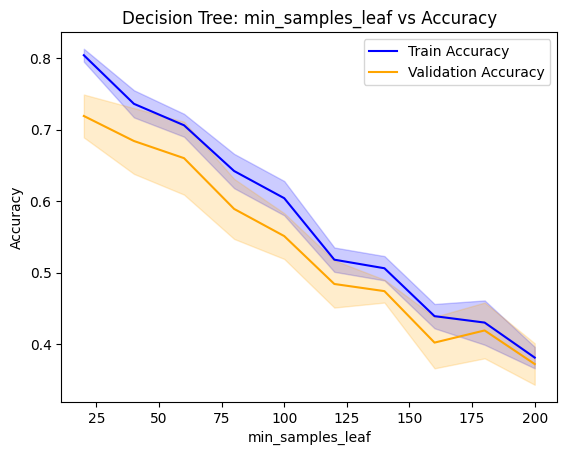

In [45]:
#2.2.2
# Plotting the graph

#Training Data
plt.plot(cv_results_df.index, cv_results_df['mean_training_accuracy'], label='Train Accuracy', color='blue')
plt.fill_between(cv_results_df.index,
                 cv_results_df['mean_training_accuracy'] - cv_results_df['std_training_accuracy'],
                 cv_results_df['mean_training_accuracy'] + cv_results_df['std_training_accuracy'],
                 color='blue', alpha=0.2)

#Validation Data
plt.plot(cv_results_df.index, cv_results_df['mean_validation_accuracy'], label='Validation Accuracy', color='orange')
plt.fill_between(cv_results_df.index,
                 cv_results_df['mean_validation_accuracy'] - cv_results_df['std_validation_accuracy'],
                 cv_results_df['mean_validation_accuracy'] + cv_results_df['std_validation_accuracy'],
                 color='orange', alpha=0.2)

plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Decision Tree: min_samples_leaf vs Accuracy')
plt.legend()
plt.show()

In [46]:
#2.3 max features vs Accuracy

max_features_values_start = np.array([1])
max_features_values_rest = np.linspace(50, 800, 18, endpoint=True)
max_features_values = np.concatenate((max_features_values_start, max_features_values_rest)).astype(int)

cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42) #n_splits = 5, so 5 fold cross validation

for max_features in max_features_values:
    training_accuracies = []
    validation_accuracies = []

    for train_index, val_index in kf.split(X):
        X_train_kf, X_val_kf = X[train_index], X[val_index]
        y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]

        dt = DecisionTreeClassifier(criterion='gini', random_state=42, max_features=max_features)
        dt.fit(X_train_kf, y_train_kf)

        train_acc = accuracy_score(y_train_kf, dt.predict(X_train_kf))
        training_accuracies.append(train_acc)

        val_acc = accuracy_score(y_val_kf, dt.predict(X_val_kf))
        validation_accuracies.append(val_acc)

    cv_results[max_features] = {
        'mean_training_accuracy': np.mean(training_accuracies),
        'std_training_accuracy': np.std(training_accuracies),
        'mean_validation_accuracy': np.mean(validation_accuracies),
        'std_validation_accuracy': np.std(validation_accuracies)
    }



     mean_training_accuracy  std_training_accuracy  mean_validation_accuracy  \
1                       1.0                    0.0                     0.458   
50                      1.0                    0.0                     0.520   
94                      1.0                    0.0                     0.569   
138                     1.0                    0.0                     0.537   
182                     1.0                    0.0                     0.607   
226                     1.0                    0.0                     0.579   
270                     1.0                    0.0                     0.622   
314                     1.0                    0.0                     0.572   
358                     1.0                    0.0                     0.620   
402                     1.0                    0.0                     0.643   
447                     1.0                    0.0                     0.611   
491                     1.0             

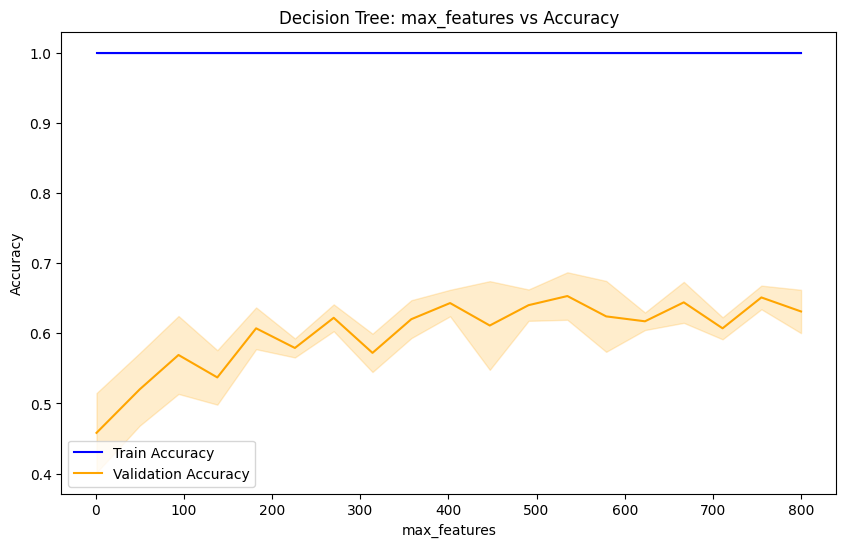

In [47]:
cv_results_df = pd.DataFrame(cv_results).T

# # cv_results_df.columns = ['Max Features'] + cv_results_df.columns[1:].tolist()
# cv_results_df.insert(0, 'Serial Number', range(1, 1 + len(cv_results_df)))

# # Name the first column as 'Max Features'
# cv_results_df.columns = ['Serial Number', 'Max Features'] + cv_results_df.columns[2:].tolist()

print(cv_results_df)



max_features_values = [
    1, 50, 94, 138, 182, 226, 270, 314, 358,
    402, 447, 491, 535, 579, 623, 667, 711, 755, 800
]

# Add a new column 'Max Features' with the provided values
cv_results_df['Max Features'] = max_features_values
cv_results_df_rounded = cv_results_df.round(3)

d1 = cv_results_df_rounded.to_dict(orient='records')
table = tabulate(d1, headers="keys", tablefmt="pretty")
print(table)


# Plotting accuracies
plt.figure(figsize=(10, 6))
# Plot training accuracy
plt.plot(max_features_values, cv_results_df['mean_training_accuracy'], label='Train Accuracy', color='blue')
plt.fill_between(max_features_values,
                 cv_results_df['mean_training_accuracy'] - cv_results_df['std_training_accuracy'],
                 cv_results_df['mean_training_accuracy'] + cv_results_df['std_training_accuracy'],
                 color='blue', alpha=0.2)

# Plot validation accuracy
plt.plot(max_features_values, cv_results_df['mean_validation_accuracy'], label='Validation Accuracy', color='orange')
plt.fill_between(max_features_values,
                 cv_results_df['mean_validation_accuracy'] - cv_results_df['std_validation_accuracy'],
                 cv_results_df['mean_validation_accuracy'] + cv_results_df['std_validation_accuracy'],
                 color='orange', alpha=0.2)

plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Decision Tree: max_features vs Accuracy')
plt.legend()
plt.show()

In [48]:
#3.2 n_estimators or numhber of trees
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

def eval_model(X, y, model, cv_param_name, cv_param_values, n_splits, init_params):
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for param_value in cv_param_values:
        fold = 0
        for train_index, test_index in skf.split(X, y):
            fold += 1
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            classifier = RandomForestClassifier(**{cv_param_name: param_value}, **init_params, random_state=42)

            classifier.fit(X_train, y_train)
            y_train_pred = classifier.predict(X_train)
            y_test_pred = classifier.predict(X_test)
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            results.append({
                cv_param_name: param_value,
                "Split Id": fold,
                "Training Accuracy": train_accuracy,
                "Validation Accuracy": test_accuracy
            })

    return pd.DataFrame(results)

In [49]:
def plot_eval(eval_df, cv_param_name, model):
    summary_train = eval_df.groupby(cv_param_name)["Training Accuracy"].agg(['mean', 'std'])
    summary_val = eval_df.groupby(cv_param_name)["Validation Accuracy"].agg(['mean', 'std'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.fill_between(summary_train.index, summary_train['mean'] - summary_train['std'],
                     summary_train['mean'] + summary_train['std'], alpha=0.1, color="blue")
    plt.fill_between(summary_val.index, summary_val['mean'] - summary_val['std'],
                     summary_val['mean'] + summary_val['std'], alpha=0.1, color="orange")

    plt.plot(summary_train.index, summary_train['mean'], color="blue", label='Train Accuracy')
    plt.plot(summary_val.index, summary_val['mean'], color="orange", label='Validation Accuracy')

    plt.title('Random Forest: n_estimators vs Accuracy')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


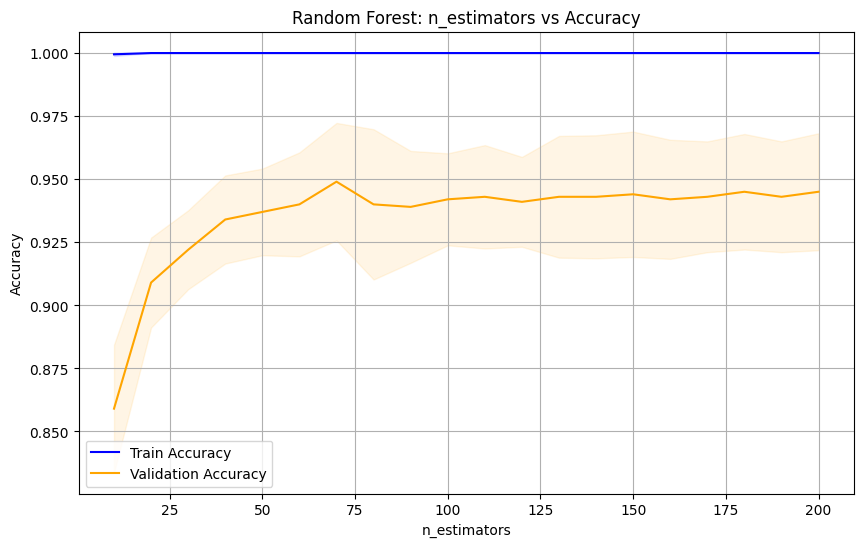

In [50]:
cv_param_values = 10 * np.arange(1, 21)  # Values from 10 to 200, stepping by 10
n_splits = 5
init_params = {}

# Assuming X and y are defined and pre-processed
eval_df = eval_model(X, y, 'Random Forest', 'n_estimators', cv_param_values, n_splits, init_params)

# Plotting the evaluation results
plot_eval(eval_df, 'n_estimators', 'Random Forest')


In [51]:
summary_stats = eval_df.groupby('n_estimators').agg({
    'Training Accuracy': ['mean', 'std'],
    'Validation Accuracy': ['mean', 'std']
}).reset_index()

#Columns of the table
summary_stats.columns = ['n_estimators', 'Training Accuracy Mean', 'Training Accuracy Std', 'Validation Accuracy Mean', 'Validation Accuracy Std']

# Display the table
summary_stats

,n_estimators,Training Accuracy Mean,Training Accuracy Std,Validation Accuracy Mean,Validation Accuracy Std
0,10,0.9995,0.000685,0.859,0.025348
1,20,1.0000,0.000000,0.909,0.017819
2,30,1.0000,0.000000,0.922,0.015652
3,40,1.0000,0.000000,0.934,0.017464
4,50,1.0000,0.000000,0.937,0.017176
5,60,1.0000,0.000000,0.940,0.020616
6,70,1.0000,0.000000,0.949,0.023292
7,80,1.0000,0.000000,0.940,0.029791
8,90,1.0000,0.000000,0.939,0.022192
9,100,1.0000,0.000000,0.942,0.018235


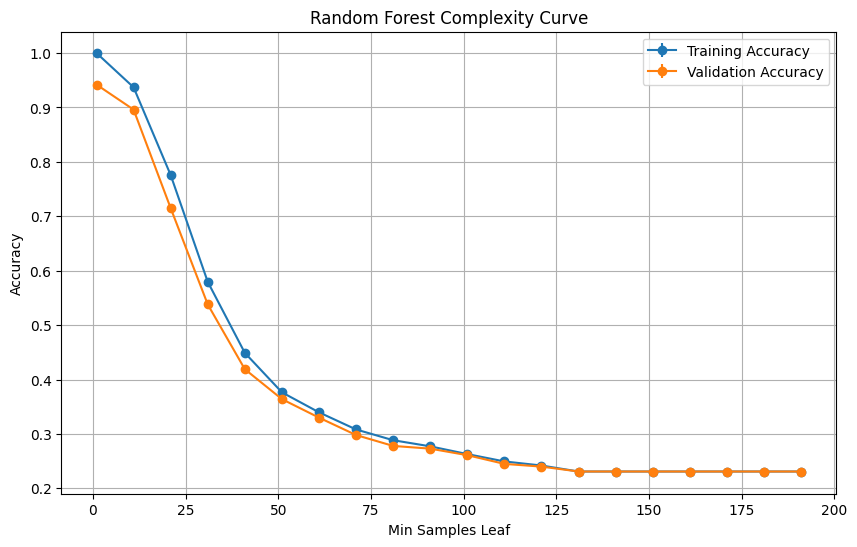

,Min Samples Leaf,Training Accuracy Mean,Validation Accuracy Mean,Training Accuracy Std,Validation Accuracy Std
0,1,1.00000,0.942,0.000559,0.002236
1,11,0.93700,0.896,0.000559,0.002236
2,21,0.77575,0.715,0.000559,0.002236
3,31,0.57950,0.538,0.000559,0.002236
4,41,0.44900,0.419,0.000559,0.002236
5,51,0.37650,0.364,0.000559,0.002236
6,61,0.33975,0.330,0.000559,0.002236
7,71,0.30825,0.298,0.000559,0.002236
8,81,0.28850,0.278,0.000559,0.002236
9,91,0.27725,0.273,0.000559,0.002236


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold


min_samples_leaf_values = np.arange(1, 201, 10)  # Evaluating from 1 to 200

# Initialize lists to store results
training_accuracy = []
validation_accuracy = []
min_samples_leaf_list = []

# Define 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each value of 'min_samples_leaf'
for min_samples_leaf in min_samples_leaf_values:
    fold_training_accuracy = []
    fold_validation_accuracy = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize the model with the current 'min_samples_leaf' value
        model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train, y_train)

        # Compute the accuracy on the training and test sets
        fold_training_accuracy.append(model.score(X_train, y_train))
        fold_validation_accuracy.append(model.score(X_test, y_test))

    # Record the average and standard deviation of the accuracies over the folds
    training_accuracy.append(np.mean(fold_training_accuracy))
    validation_accuracy.append(np.mean(fold_validation_accuracy))
    min_samples_leaf_list.append(min_samples_leaf)

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Min Samples Leaf': min_samples_leaf_list,
    'Training Accuracy Mean': training_accuracy,
    'Validation Accuracy Mean': validation_accuracy,
    'Training Accuracy Std': np.std(fold_training_accuracy, ddof=1),
    'Validation Accuracy Std': np.std(fold_validation_accuracy, ddof=1)
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['Min Samples Leaf'], results_df['Training Accuracy Mean'],
             yerr=results_df['Training Accuracy Std'], label='Training Accuracy', fmt='-o')
plt.errorbar(results_df['Min Samples Leaf'], results_df['Validation Accuracy Mean'],
             yerr=results_df['Validation Accuracy Std'], label='Validation Accuracy', fmt='-o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Random Forest Complexity Curve')
plt.legend()
plt.grid(True)
plt.show()

# Display the results table
results_df


In [80]:
test_data = pd.read_csv('/content/drive/MyDrive/HW1/news-test.csv') # Load test dataset
training_data = pd.read_csv('/content/drive/MyDrive/HW1/24_train_1.csv') # Load training dataset

X_test_tfidf  = tfidf_vectorizer.transform(test_data['Text'])

In [81]:
classifiers  = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [82]:
label_enc = LabelEncoder()
y_train_encoded = label_enc.fit_transform(training_data['Category'])

evaluation_results = {}
for clf_name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X, y_train_encoded, cv=5)
    evaluation_results[clf_name] = {
        "Mean_Accuracy": np.mean(cv_scores),
        "Standard_Deviation": np.std(cv_scores)
    }

In [83]:
for clf in evaluation_results:
    print(f"{clf}: Mean Accuracy = {evaluation_results[clf]['Mean_Accuracy']:.4f}, Standard Deviation = {evaluation_results[clf]['Standard_Deviation']:.4f}")

Decision Tree: Mean Accuracy = 0.8090, Standard Deviation = 0.0229
Random Forest: Mean Accuracy = 0.9350, Standard Deviation = 0.0161


In [85]:
optimal_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y_train_encoded)
test_predictions = optimal_model.predict(X_test_tfidf)
predicted_categories = label_enc.inverse_transform(test_predictions)

In [88]:
submission_data = pd.DataFrame({'Article_ID': test_data['ArticleId'], 'Predicted_Category': predicted_categories})
submission_data.to_csv('labels.csv', index=False, header=False)